In [25]:
import pandas as pd
import PyPDF2
import numpy as np
import math
from extractors.abstract_extractor import AbstractExractor
from utils.data.visualisation import visualiseIndividualfromDF, visualiseIndividualinMPL
from utils.misc.datastructure import perform_shape_switch
from tools.extraction_tools import extract_PDF_raw, extract_leads_numeric, move_trace_to_origin, scale_values_using_cal_mark, \
    create_measurement_points, perform_shape_switch, adjust_leads_baseline
import logging
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show
from bokeh.io import output_notebook


<font color='green'>**Import leads from PDF EKG as numeric values**</font>


In [4]:
# reference value for the calibration jag
cal_ref = 1000

# extracted height for the calibration jag in PDF (extract pixel height from PDF)
#orginal provided measurement from codebase 28.34800000000001 (height that is read in via pdf reader)
#extracted by measuring pixel height in Illustrator (28.35)
cal_height = 1000 #height that is read in with pdf reader with our EKG pdfs


# factor for scaling (effectively gamma = 1 based on read in structure from GE EKGs)
gamma = cal_ref / cal_height

# name of the leads
lead_names_short = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
lead_names_long = ['V1','II',"V5"]

#source data
path_source = os.getcwd()
#data_source = 'data_test\\EKG_131515-20_0.pdf'
#data_source = 'data_test\\EKG_131515-33_0.pdf'
data_source = 'data_test\\EKG_131515-119_0.pdf'

filename = os.path.join(path_source, data_source)

#Extract raw PDF data from source file
pdf_object = extract_PDF_raw(filename)


#define dict with index ranges for graphics object corresponding to leads/cal marker
range_list = {
    #range of lead extraction (short leads)
    'start_idx': 412,
    'end_idx'  : 423,
    #range of lead extraction (long leads)
    'start_idx_long': 427,
    'end_idx_long': 429,
    #calibration marker index
    'cal_idx' : 424
}

#Extract numeric x,y points for each lead 
lead_numeric = extract_leads_numeric(range_list,pdf_object)

#Shift traces to common origin
shift_leads = list(map(move_trace_to_origin, lead_numeric))

#Scale leads by gamma factor (gamma = 1 for current EKG PDFs)
scale_shift_leads = [scale_values_using_cal_mark(l, gamma) for l in shift_leads]

#convert traces to by linear interpolation to timepoints along sampling frequency (500 Hz)
#for 2.5s strips (500Hz acquisition freq for 2.5s)
sample_points = 1250
leads_upsampled = [create_measurement_points(l, sample_points) for l in scale_shift_leads[0:12]]

#for 10s strips (500Hz acquisition frq for 10s)
sample_points = 5000
leads_upsampled.extend([create_measurement_points(l, sample_points) for l in scale_shift_leads[13:16]])

# Convert short lead list to dataframe
df_leads = pd.DataFrame(perform_shape_switch(leads_upsampled[0:12]), columns=lead_names_short)

# Adjust baseline position of each lead
df_leads = adjust_leads_baseline(df_leads)


<font color='green'>**Plot traces for each lead**</font>

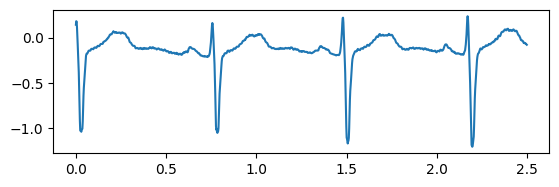

In [23]:
#Voltage scale
#1000 points = 10 mm = 10cm = 1 mV => 1 point = 0.001 mV
#10 mm/mV ==> 25 mm = 2.5 mV = 2500 points
voltage_arr = df_leads['V3']*0.001

#Time scale
#1250 points = 2.5s ==> 1 point = 0.002s
#25 mm/s =  25 mm = 1 s 500 points 
#1mm = 0.04s 
time_arr = np.arange(0, 2.500, 0.002)

#Dell P3421W
#109 PPI 
#43 ppcm
#pixel_pitch = 0.2325 mm
#107.52 pixels = 25 mm = 1s

#Voltage/time aspect ration for 25 mm/s speed ()
aspect_ratio = 0.5

#Plot origin shifted traces
fig, ax = plt.subplots()
ax.plot(time_arr,voltage_arr)
ax.set_aspect(aspect_ratio)
plt.show()

#ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#       ylim=(0, 8), yticks=np.arange(1, 8))

<font color='green'>**Interactive plots**</font>

In [26]:
p = figure(width=400, height=400)

# add a line renderer with NaN values
p.line(time_arr, voltage_arr, line_width=2)

show(p)